In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station



In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
m_columns = inspector.get_columns('Measurement')

for c in m_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Find the most recent date in the data set.
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
max_date



('2017-08-23')

<AxesSubplot:xlabel='Date'>

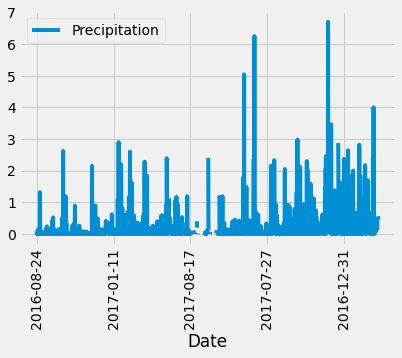

In [35]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
query_date = dt.datetime(2017, 8, 23) - dt.timedelta(days=365)

query_date

# Perform a query to retrieve the data and precipitation scores
last_year_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).all()


# # Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(last_year_prcp, columns = ['Date', 'Precipitation'])
df.set_index('Date')
# Sort the dataframe by date
df = df.sort_index()

df = df.reset_index()


# # Use Pandas Plotting with Matplotlib to plot the data

df.plot(x= 'Date', y= 'Precipitation',rot=90)
# plt.xlabel("")



In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
new_df['Precipitation'].describe()

count    365.000000
mean       0.974164
std        1.776466
min        0.000000
25%        0.050000
50%        0.400000
75%        1.080000
max       14.280000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
s_columns = inspector.get_columns('Station')

for c in s_columns:
    print(c['name'], c["type"])

    
station_name = session.query(Station.station).group_by(Station.station).count()
station_name

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


9

In [16]:

# Design a query to find the most active stations (i.e. what stations have the most rows?)

station_numbers = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(Measurement.station).all()

station_numbers_df=pd.DataFrame(station_numbers, columns = ['Station_Name', 'Number_of_Reports'])
station_desc=station_numbers_df.sort_values('Number_of_Reports', ascending=False)
station_info =station_desc.set_index('Station_Name')

station_info


,Number_of_Reports
Station_Name,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


Temp_data_top_station = session.query(Measurement.tobs, Measurement.station, Measurement.date).\
    filter(Measurement.station == 'USC00519281').all()

top_temp_s_df = pd.DataFrame(Temp_data_top_station, columns = ['Tempature', 'Station', 'Date'])
top_temp_s_df

max_temp = top_temp_s_df['Tempature'].max()
max_temp

low_temp = top_temp_s_df['Tempature'].min()
low_temp

avg_temp = top_temp_s_df['Tempature'].mean()

avg_temp

71.66378066378067

In [22]:
from sqlalchemy import or_, and_


weather_year_top = session.query(Measurement.tobs, Measurement.station, Measurement.date).\
    filter(and_(Measurement.date > query_date, Measurement.station == 'USC00519281'))



Top_station_temp_year_df = pd.DataFrame(weather_year_top, columns = ['Temp','Station','Date'])

Top_station_temp_year_df.head()

,Temp,Station,Date
0,77.0,USC00519281,2016-08-24
1,80.0,USC00519281,2016-08-25
2,80.0,USC00519281,2016-08-26
3,75.0,USC00519281,2016-08-27
4,73.0,USC00519281,2016-08-28


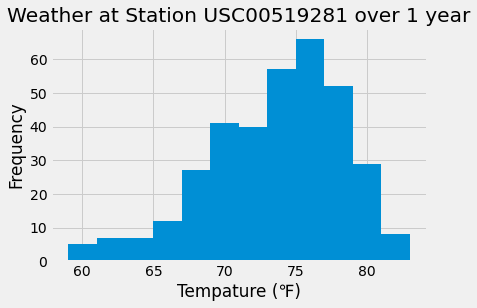

In [23]:
a =Top_station_temp_year_df['Temp']
plt.style.use('fivethirtyeight')

a.hist(bins =12)

plt.title('Weather at Station USC00519281 over 1 year')
plt.xlabel('Tempature (℉)')
plt.ylabel('Frequency')
plt.show()



# Close session

In [20]:
# Close Session
session.close()